In [1]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from fbprophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


In [2]:
stock = pd.read_csv('SH600000.csv')
dates = pd.read_excel('dates.xlsx',index_col=0).drop('Unnamed: 2',axis=1)
data = pd.concat([dates, stock['Close']], axis=1)
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']
data.drop(['Date'], axis=1, inplace=True)
data

,Close
Date,
2018-01-01,156.9592
2018-01-02,156.5883
2018-01-03,158.4426
2018-01-04,159.5551
2018-01-05,160.0186
...,...
2020-11-17,158.0162
2020-11-18,155.2172
2020-11-19,156.2351


In [49]:
dataset = data.values
train = dataset[:504,:]
test = dataset[504:,:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

inW, outW = 250, 5
x_train, y_train = [], []
for i in range(inW,len(train),outW):
    x_train.append(scaled_data[i-inW:i,0])
    y_train.append(scaled_data[i:i+outW,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(outW))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 5 days' prices, using past 250 days from the train data
inputs = data[len(data) - len(test) - inW:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(inW,inputs.shape[0],outW):
    X_test.append(inputs[i-inW:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price.reshape(-1,1)[:len(test)]

Epoch 1/1
 - 9s - loss: 0.0586


In [50]:
len(test)

252

In [44]:
rms = np.sqrt(np.mean(np.power((test-closing_price),2)))
rms

5.953556217042307

C:\Users\rajat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


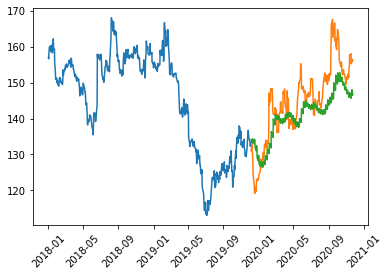

In [5]:
train = data[:504]
test = data[504:]
test['Predictions'] = closing_price
fig = plt.figure()
plt.plot(train['Close'])
plt.plot(test[['Close','Predictions']])
plt.xticks(rotation=45)
plt.show()
fig.savefig('test10.png')